# MaxSold Items - NLP Analysis

Natural Language Processing analysis of item titles and descriptions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from pathlib import Path

# NLP libraries
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Load Data

In [3]:
# Load the parquet file
data_path = Path('/workspaces/maxsold/data/items_details/items_details_20251201.parquet')
df = pd.read_parquet(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Display first few rows
df.head()

Dataset shape: (229125, 17)

Columns: ['id', 'auction_id', 'title', 'description', 'taxable', 'viewed', 'minimum_bid', 'starting_bid', 'current_bid', 'proxy_bid', 'start_time', 'end_time', 'lot_number', 'bid_count', 'bidding_extended', 'buyer_premium', 'timezone']


,id,auction_id,title,description,taxable,viewed,minimum_bid,starting_bid,current_bid,proxy_bid,start_time,end_time,lot_number,bid_count,bidding_extended,buyer_premium,timezone
0,7490263,103882,Gorgeous AAA Untreated Opal,"Big 7.28ct AAA beautiful untreated Ethiopian opal. \nWith catsey/floral play of color patterns, ...",True,191,25.00,1,22.00,0,2025-11-24 17:00:00-05:00,2025-11-30 20:15:00-05:00,1,5,False,18,America/New_York
1,7490264,103882,Natural High Quality Emerald,"1.50ct natural beautiful, high quality \nEmerald. \nVs clarity beautiful color \nEmerald cut thi...",True,507,56.67,1,51.67,0,2025-11-24 17:00:00-05:00,2025-11-30 20:15:00-05:00,2,15,False,18,America/New_York
2,7490265,103882,Natural Ruby,"4.74ct natural deep red\nOctagon Ruby \n13x7mm\nSi1 clarity \nHeated, clarity enhanced \n\nWe gu...",True,477,28.00,1,25.00,0,2025-11-24 17:00:00-05:00,2025-11-30 20:15:00-05:00,3,7,False,18,America/New_York
3,7490266,103882,Natural Green Tourmaline,1.84ct natural baguette cut\nGreen tourmaline \nVs-vvs clarity \nGreat luster\n11.2x4.8mm\n\nWe ...,True,143,4.00,1,3.00,0,2025-11-24 17:00:00-05:00,2025-11-30 20:15:00-05:00,4,3,False,18,America/New_York
4,7490267,103882,Natural Bicolored Tourmaline,3.05ct pear cut 2pcs\nUntreated bicolored tourmaline. \nHas some inclusions \nBlue pink\n\nWe gu...,True,291,10.00,1,9.00,0,2025-11-24 17:00:00-05:00,2025-11-30 20:16:32-05:00,5,9,True,18,America/New_York


## Text Column Overview

In [4]:
# Check if title and description columns exist
text_cols = [col for col in df.columns if 'title' in col.lower() or 'description' in col.lower()]
print(f"Text columns found: {text_cols}")

# Select the title and description columns (adjust names as needed)
title_col = next((col for col in df.columns if 'title' in col.lower()), None)
desc_col = next((col for col in df.columns if 'description' in col.lower()), None)

if title_col:
    print(f"\nTitle column: {title_col}")
    print(f"Non-null titles: {df[title_col].notna().sum()} ({df[title_col].notna().sum()/len(df)*100:.1f}%)")
    
if desc_col:
    print(f"\nDescription column: {desc_col}")
    print(f"Non-null descriptions: {df[desc_col].notna().sum()} ({df[desc_col].notna().sum()/len(df)*100:.1f}%)")

Text columns found: ['title', 'description']

Title column: title
Non-null titles: 229125 (100.0%)

Description column: description
Non-null descriptions: 229125 (100.0%)


In [5]:
# Sample titles and descriptions
if title_col:
    print("\n=== Sample Titles ===")
    print(df[title_col].dropna().head(10).to_string(index=False))

if desc_col:
    print("\n=== Sample Descriptions ===")
    print(df[desc_col].dropna().head(5).to_string(index=False))


=== Sample Titles ===
        Gorgeous AAA  Untreated Opal
        Natural High Quality Emerald
                        Natural Ruby
            Natural Green Tourmaline
        Natural Bicolored Tourmaline
      High Quality Natural Tanzanite
       Natural Silver Sheen Obsidian
Natural Deep Rich Colored Tourmaline
                Big Natural Amethyst
      Natural High Quality Tanzanite

=== Sample Descriptions ===
Big 7.28ct AAA beautiful untreated Ethiopian opal. \nWith catsey/floral play of color patterns, r...
1.50ct natural beautiful, high quality \nEmerald. \nVs clarity beautiful color \nEmerald cut this...
4.74ct natural deep red\nOctagon Ruby \n13x7mm\nSi1 clarity \nHeated, clarity enhanced \n\nWe gua...
1.84ct natural baguette cut\nGreen tourmaline \nVs-vvs clarity \nGreat luster\n11.2x4.8mm\n\nWe g...
3.05ct pear cut 2pcs\nUntreated bicolored tourmaline. \nHas some inclusions \nBlue pink\n\nWe gua...


## Text Statistics

In [6]:
def text_statistics(series, name):
    """Calculate text statistics for a series"""
    series_clean = series.dropna().astype(str)
    
    stats = {
        'Total Records': len(series),
        'Non-null Records': len(series_clean),
        'Avg Length (chars)': series_clean.str.len().mean(),
        'Max Length (chars)': series_clean.str.len().max(),
        'Min Length (chars)': series_clean.str.len().min(),
        'Avg Word Count': series_clean.str.split().str.len().mean(),
        'Max Word Count': series_clean.str.split().str.len().max(),
        'Min Word Count': series_clean.str.split().str.len().min(),
    }
    
    print(f"\n=== {name} Statistics ===")
    for key, value in stats.items():
        print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")
    
    return series_clean

# Calculate statistics
if title_col:
    titles = text_statistics(df[title_col], "Titles")

if desc_col:
    descriptions = text_statistics(df[desc_col], "Descriptions")


=== Titles Statistics ===
Total Records: 229125
Non-null Records: 229125
Avg Length (chars): 37.79
Max Length (chars): 175
Min Length (chars): 2
Avg Word Count: 5.97
Max Word Count: 31
Min Word Count: 1

=== Descriptions Statistics ===
Total Records: 229125
Non-null Records: 229125
Avg Length (chars): 203.90
Max Length (chars): 5464
Min Length (chars): 0
Avg Word Count: 30.48
Max Word Count: 822
Min Word Count: 0


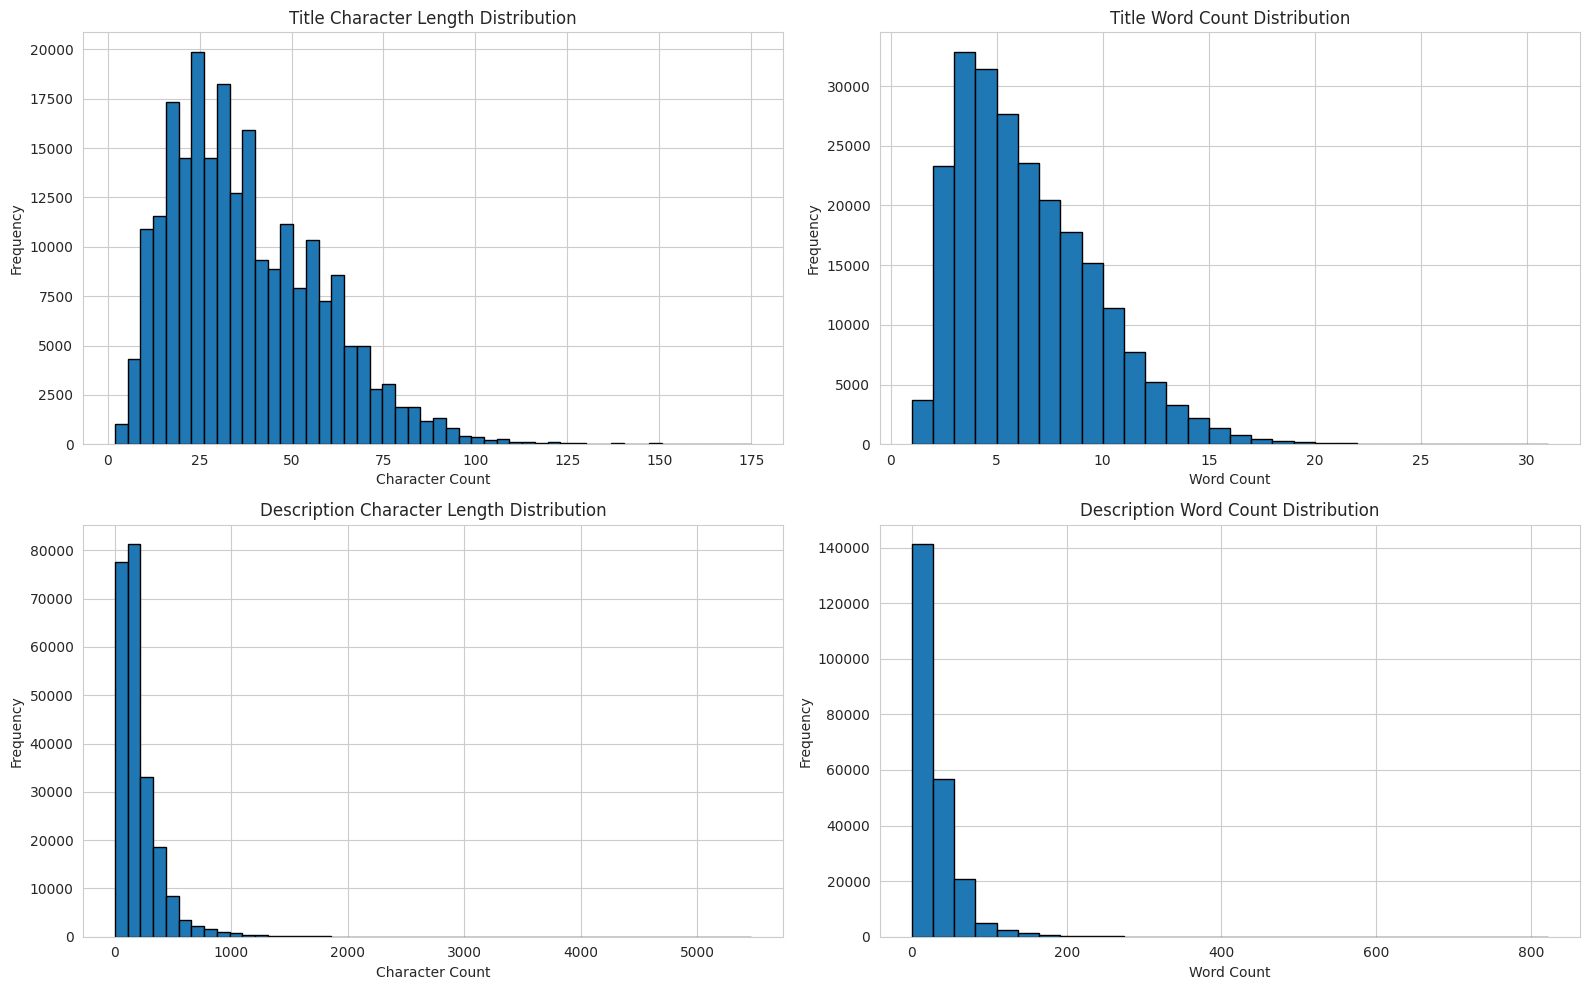

In [7]:
# Plot length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

if title_col:
    # Title character length
    titles.str.len().hist(bins=50, ax=axes[0, 0], edgecolor='black')
    axes[0, 0].set_title('Title Character Length Distribution')
    axes[0, 0].set_xlabel('Character Count')
    axes[0, 0].set_ylabel('Frequency')
    
    # Title word count
    titles.str.split().str.len().hist(bins=30, ax=axes[0, 1], edgecolor='black')
    axes[0, 1].set_title('Title Word Count Distribution')
    axes[0, 1].set_xlabel('Word Count')
    axes[0, 1].set_ylabel('Frequency')

if desc_col:
    # Description character length
    descriptions.str.len().hist(bins=50, ax=axes[1, 0], edgecolor='black')
    axes[1, 0].set_title('Description Character Length Distribution')
    axes[1, 0].set_xlabel('Character Count')
    axes[1, 0].set_ylabel('Frequency')
    
    # Description word count
    descriptions.str.split().str.len().hist(bins=30, ax=axes[1, 1], edgecolor='black')
    axes[1, 1].set_title('Description Word Count Distribution')
    axes[1, 1].set_xlabel('Word Count')
    axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Text Preprocessing

In [8]:
def preprocess_text(text, remove_stopwords=True):
    """Preprocess text: lowercase, remove punctuation, tokenize"""
    if pd.isna(text):
        return []
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    return tokens

# Preprocess titles and descriptions
if title_col:
    print("Preprocessing titles...")
    df['title_tokens'] = df[title_col].apply(preprocess_text)
    print(f"Sample tokenized title: {df['title_tokens'].iloc[0]}")

if desc_col:
    print("\nPreprocessing descriptions...")
    df['desc_tokens'] = df[desc_col].apply(preprocess_text)
    print(f"Sample tokenized description: {df['desc_tokens'].iloc[0][:20]}...")  # First 20 tokens

Preprocessing titles...
Sample tokenized title: ['gorgeous', 'aaa', 'untreated', 'opal']

Preprocessing descriptions...
Sample tokenized description: ['big', 'aaa', 'beautiful', 'untreated', 'ethiopian', 'opal', 'catseyfloral', 'play', 'color', 'patterns', 'rainbow', 'saturation', 'xmm', 'guarantee', 'authenticity', 'gemstones', 'jewelry', 'everything', 'verified', 'atleast']...


## Word Frequency Analysis

In [9]:
def get_word_frequency(token_series, top_n=30):
    """Get word frequency from tokenized text"""
    all_words = [word for tokens in token_series for word in tokens]
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

# Get top words for titles
if title_col:
    print("\n=== Top 30 Words in Titles ===")
    title_freq = get_word_frequency(df['title_tokens'], top_n=30)
    title_freq_df = pd.DataFrame(title_freq, columns=['Word', 'Frequency'])
    print(title_freq_df.to_string(index=False))

# Get top words for descriptions
if desc_col:
    print("\n=== Top 30 Words in Descriptions ===")
    desc_freq = get_word_frequency(df['desc_tokens'], top_n=30)
    desc_freq_df = pd.DataFrame(desc_freq, columns=['Word', 'Frequency'])
    print(desc_freq_df.to_string(index=False))


=== Top 30 Words in Titles ===
    Word  Frequency
 vintage      32727
     lot      19873
     set      11503
   glass       9093
  silver       7038
     new       6894
 antique       6694
   table       6633
     art       6444
   large       4706
    wood       4575
     box       4471
  framed       4454
  signed       4432
   black       4290
   metal       4150
    blue       3873
 natural       3822
assorted       3720
  wooden       3596
   books       3509
    size       3494
    lamp       3421
    book       3383
painting       3322
   print       3316
   white       3239
    wall       3232
    pair       3117
    hand       3082

=== Top 30 Words in Descriptions ===
        Word  Frequency
    category     229156
    timeslot     228796
      pickup     185832
   condition      76585
        nbsp      58632
        good      37421
     vintage      34844
        wear      28003
         see      25835
       bring      23190
      inches      22336
measurements      2150

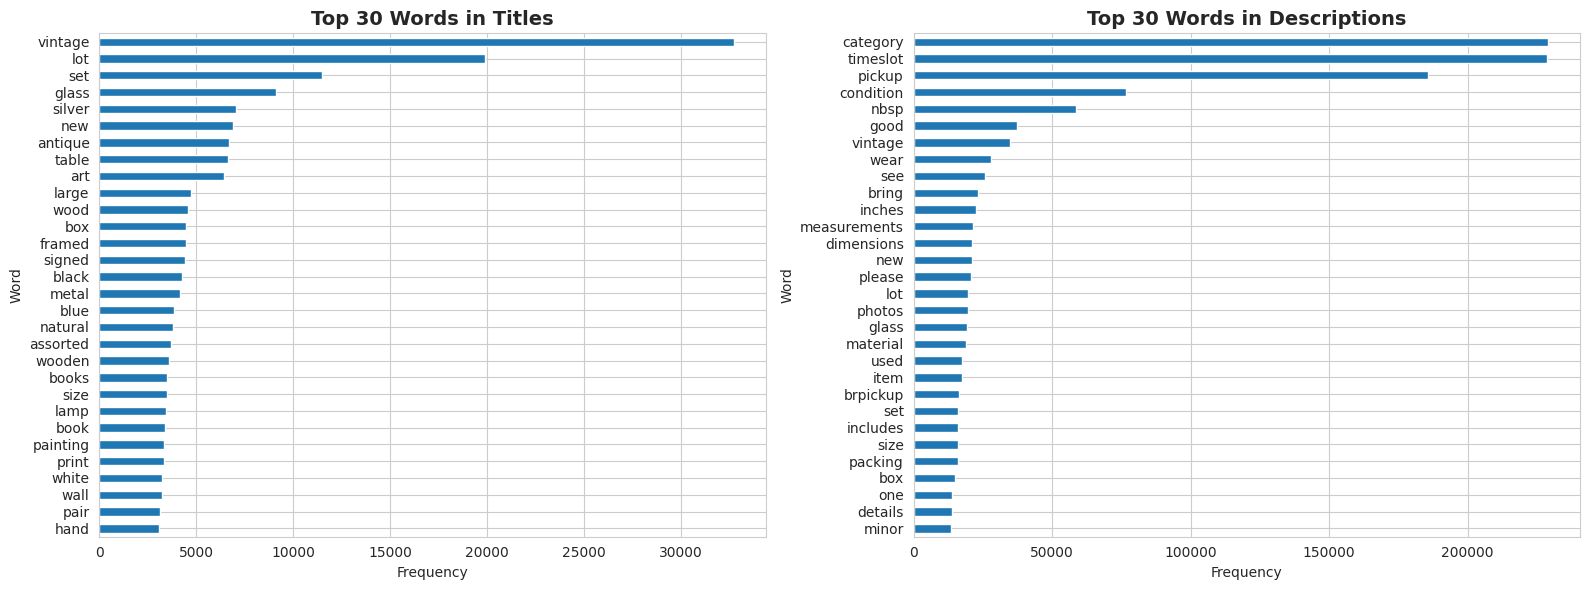

In [10]:
# Plot top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if title_col:
    title_freq_df.plot(x='Word', y='Frequency', kind='barh', ax=axes[0], legend=False)
    axes[0].set_title('Top 30 Words in Titles', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Frequency')
    axes[0].set_ylabel('Word')
    axes[0].invert_yaxis()

if desc_col:
    desc_freq_df.plot(x='Word', y='Frequency', kind='barh', ax=axes[1], legend=False)
    axes[1].set_title('Top 30 Words in Descriptions', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Frequency')
    axes[1].set_ylabel('Word')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Word Clouds

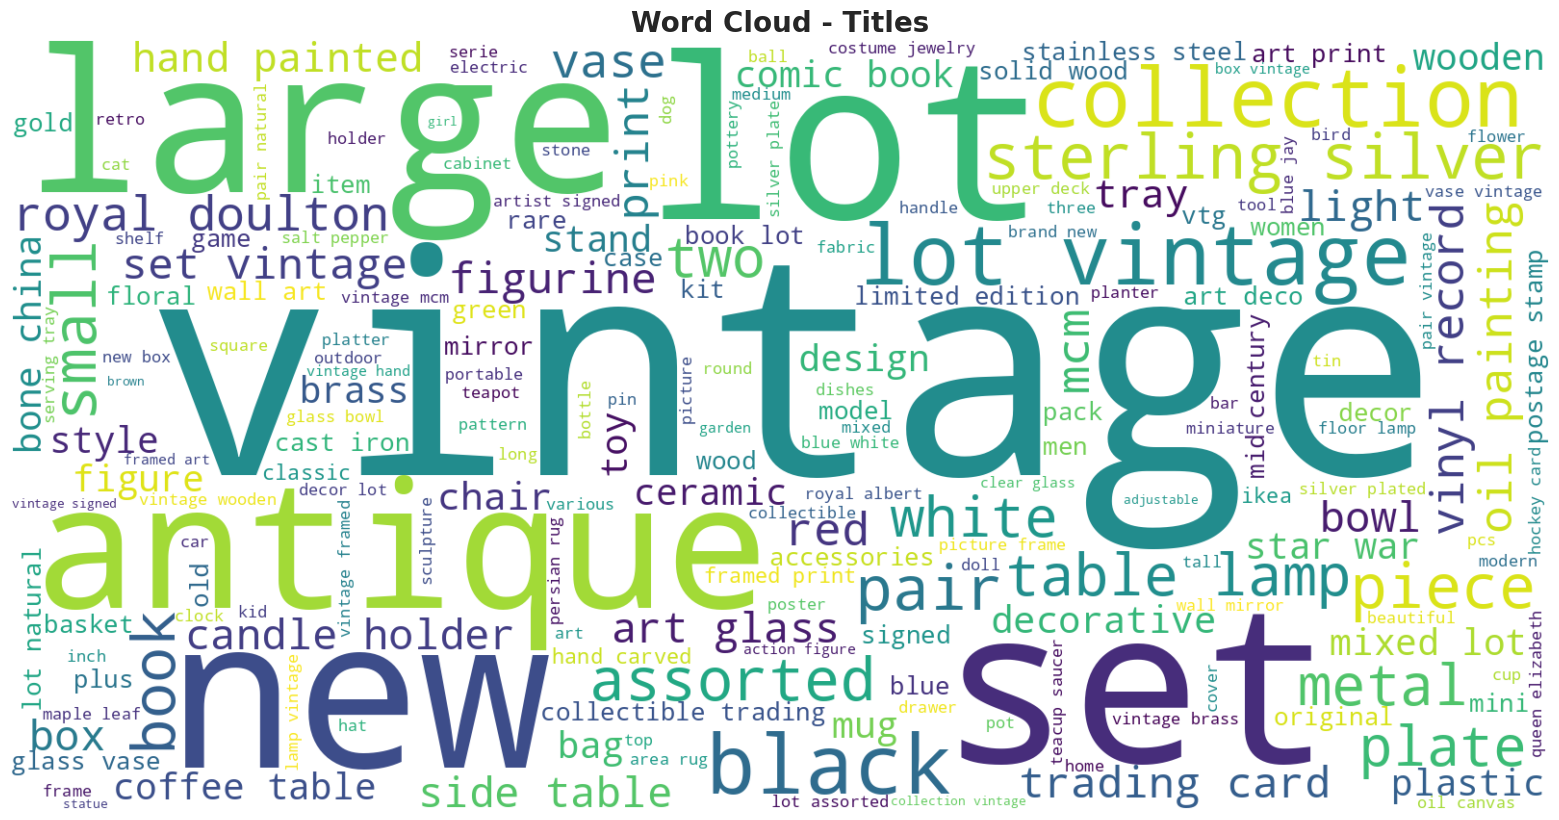

: 

In [11]:
def create_wordcloud(token_series, title):
    """Create word cloud from tokenized text"""
    all_words = ' '.join([' '.join(tokens) for tokens in token_series])
    
    wordcloud = WordCloud(
        width=1600,
        height=800,
        background_color='white',
        colormap='viridis',
        max_words=200,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(all_words)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20, fontweight='bold')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Create word clouds
if title_col:
    create_wordcloud(df['title_tokens'], 'Word Cloud - Titles')

if desc_col:
    create_wordcloud(df['desc_tokens'], 'Word Cloud - Descriptions')

## N-gram Analysis

In [1]:
def get_ngrams(token_series, n=2, top_n=20):
    """Extract n-grams from tokenized text"""
    all_ngrams = []
    for tokens in token_series:
        if len(tokens) >= n:
            all_ngrams.extend(list(ngrams(tokens, n)))
    
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_n)

# Bigrams (2-word phrases)
if title_col:
    print("\n=== Top 20 Bigrams in Titles ===")
    title_bigrams = get_ngrams(df['title_tokens'], n=2, top_n=20)
    for bigram, freq in title_bigrams:
        print(f"{' '.join(bigram)}: {freq}")

if desc_col:
    print("\n=== Top 20 Bigrams in Descriptions ===")
    desc_bigrams = get_ngrams(df['desc_tokens'], n=2, top_n=20)
    for bigram, freq in desc_bigrams:
        print(f"{' '.join(bigram)}: {freq}")

NameError: name 'title_col' is not defined

In [ ]:
# Trigrams (3-word phrases)
if title_col:
    print("\n=== Top 20 Trigrams in Titles ===")
    title_trigrams = get_ngrams(df['title_tokens'], n=3, top_n=20)
    for trigram, freq in title_trigrams:
        print(f"{' '.join(trigram)}: {freq}")

if desc_col:
    print("\n=== Top 20 Trigrams in Descriptions ===")
    desc_trigrams = get_ngrams(df['desc_tokens'], n=3, top_n=20)
    for trigram, freq in desc_trigrams:
        print(f"{' '.join(trigram)}: {freq}")

In [ ]:
# Plot bigrams
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

if title_col:
    title_bigram_df = pd.DataFrame(
        [(' '.join(bg), freq) for bg, freq in title_bigrams],
        columns=['Bigram', 'Frequency']
    )
    title_bigram_df.plot(x='Bigram', y='Frequency', kind='barh', ax=axes[0], legend=False)
    axes[0].set_title('Top 20 Bigrams in Titles', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Frequency')
    axes[0].set_ylabel('Bigram')
    axes[0].invert_yaxis()

if desc_col:
    desc_bigram_df = pd.DataFrame(
        [(' '.join(bg), freq) for bg, freq in desc_bigrams],
        columns=['Bigram', 'Frequency']
    )
    desc_bigram_df.plot(x='Bigram', y='Frequency', kind='barh', ax=axes[1], legend=False)
    axes[1].set_title('Top 20 Bigrams in Descriptions', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Frequency')
    axes[1].set_ylabel('Bigram')
    axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Unique Words Analysis

In [ ]:
# Vocabulary size
if title_col:
    unique_title_words = set([word for tokens in df['title_tokens'] for word in tokens])
    print(f"Unique words in titles: {len(unique_title_words)}")

if desc_col:
    unique_desc_words = set([word for tokens in df['desc_tokens'] for word in tokens])
    print(f"Unique words in descriptions: {len(unique_desc_words)}")

# Words that appear in titles but not descriptions
if title_col and desc_col:
    title_only_words = unique_title_words - unique_desc_words
    desc_only_words = unique_desc_words - unique_title_words
    common_words = unique_title_words & unique_desc_words
    
    print(f"\nWords only in titles: {len(title_only_words)}")
    print(f"Words only in descriptions: {len(desc_only_words)}")
    print(f"Common words: {len(common_words)}")
    
    print(f"\nSample title-only words: {list(title_only_words)[:20]}")
    print(f"Sample description-only words: {list(desc_only_words)[:20]}")

## Part-of-Speech Tagging

In [ ]:
def extract_pos_tags(text, top_n=20):
    """Extract and count part-of-speech tags"""
    if pd.isna(text):
        return []
    
    tokens = word_tokenize(str(text).lower())
    pos_tags = nltk.pos_tag(tokens)
    return pos_tags

# Extract POS tags for a sample
if title_col:
    sample_titles = df[title_col].dropna().head(100)
    title_pos_tags = [tag for text in sample_titles for _, tag in extract_pos_tags(text)]
    title_pos_freq = Counter(title_pos_tags).most_common(15)
    
    print("\n=== Top POS Tags in Titles (sample) ===")
    for tag, freq in title_pos_freq:
        print(f"{tag}: {freq}")

if desc_col:
    sample_descs = df[desc_col].dropna().head(100)
    desc_pos_tags = [tag for text in sample_descs for _, tag in extract_pos_tags(text)]
    desc_pos_freq = Counter(desc_pos_tags).most_common(15)
    
    print("\n=== Top POS Tags in Descriptions (sample) ===")
    for tag, freq in desc_pos_freq:
        print(f"{tag}: {freq}")

## Summary Statistics

In [ ]:
# Create summary report
summary = {}

if title_col:
    summary['Titles'] = {
        'Total Records': len(df),
        'Non-null': df[title_col].notna().sum(),
        'Avg Length (chars)': titles.str.len().mean(),
        'Avg Words': titles.str.split().str.len().mean(),
        'Vocabulary Size': len(unique_title_words),
        'Most Common Word': title_freq[0][0] if title_freq else 'N/A',
        'Most Common Bigram': ' '.join(title_bigrams[0][0]) if title_bigrams else 'N/A'
    }

if desc_col:
    summary['Descriptions'] = {
        'Total Records': len(df),
        'Non-null': df[desc_col].notna().sum(),
        'Avg Length (chars)': descriptions.str.len().mean(),
        'Avg Words': descriptions.str.split().str.len().mean(),
        'Vocabulary Size': len(unique_desc_words),
        'Most Common Word': desc_freq[0][0] if desc_freq else 'N/A',
        'Most Common Bigram': ' '.join(desc_bigrams[0][0]) if desc_bigrams else 'N/A'
    }

summary_df = pd.DataFrame(summary).T
print("\n=== NLP Summary Report ===")
print(summary_df)